In [ ]:
import matplotlib.pyplot as plt
import time
import warnings
import numpy as np
import os
import scipy.io as sio
import seaborn as sns
import pandas as pd
from operator import truediv
import spectral
from sklearn.decomposition import (IncrementalPCA, PCA)
from sklearn.metrics import (accuracy_score, classification_report,
                             cohen_kappa_score, confusion_matrix)
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
from tensorflow.keras import initializers, constraints
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Input, InputSpec, Add, AveragePooling2D, LeakyReLU, Multiply, 
                                     Conv3D, Conv2D, Conv1D, BatchNormalization,
                                     GlobalAveragePooling2D, GlobalMaxPooling2D, DepthwiseConv2D, Layer, Dense, 
                                     Layer, Dropout, Activation, Flatten, Reshape, Concatenate, MaxPooling2D)
from keras.losses import categorical_crossentropy
from keras.utils import to_categorical
from keras.optimizers import legacy
from tensorflow.keras.optimizers import Adam
from keras.optimizers import Adam

2024-09-28 22:09:30.430418: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-28 22:09:30.908815: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-28 22:09:30.908888: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-28 22:09:30.990549: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-28 22:09:31.162039: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
## Loading Hyperspectral Datasets
def LoadHSIData(method):
    data_path = os.path.join(os.getcwd(),'../HSI/')
    if method == 'UH':
      HSI = sio.loadmat(os.path.join(data_path, 'HU.mat'))['HSI']
      GT = sio.loadmat(os.path.join(data_path, 'HU_gt.mat'))['gt']
      Num_Classes = 15
      target_names = ['Healthy grass', 'Stressed grass', 'Synthetic grass', 'Trees',
                    'Soil', 'Water', 'Residential', 'Commercial', 'Road',
                    'Highway', 'Railway', 'Parking Lot 1', 'Parking Lot 2',
                    'Tennis Court', 'Running Track']
    return HSI, GT, Num_Classes, target_names
## Dimensional Reduction Methods
def DLMethod(method, HSI, NC = 75):
    RHSI = np.reshape(HSI, (-1, HSI.shape[2]))
    if method == 'PCA': ## PCA
        pca = PCA(n_components = NC, whiten = True)
        RHSI = pca.fit_transform(RHSI)
        RHSI = np.reshape(RHSI, (HSI.shape[0], HSI.shape[1], NC))
    elif method == 'iPCA': ## Incremental PCA
        n_batches = 256
        inc_pca = IncrementalPCA(n_components = NC)
        for X_batch in np.array_split(RHSI, n_batches):
          inc_pca.partial_fit(X_batch)
        X_ipca = inc_pca.transform(RHSI)
        RHSI = np.reshape(X_ipca, (HSI.shape[0], HSI.shape[1], NC))
    return RHSI

def TrTeSplit(HSI, GT, trRatio, vrRatio, teRatio, randomState=345):
    # Split into train and test sets
    Tr, Te, TrC, TeC = train_test_split(HSI, GT, test_size=teRatio,
                                        random_state=randomState, stratify=GT)
    totalTrRatio = trRatio + vrRatio
    new_vrRatio = vrRatio / totalTrRatio
    Tr, Va, TrC, VaC = train_test_split(Tr, TrC, test_size=new_vrRatio,
                                        random_state=randomState, stratify=TrC)
    return Tr, Va, Te, TrC, VaC, TeC

## Global Parameters
HSID = "UH"
DLM = "PCA"
WS = 4
teRatio = 0.50
vrRatio = 0.50
trRatio = 0.50
k = 15
adam = tf.keras.optimizers.legacy.Adam(lr = 0.001, decay = 1e-06)
epochs = 50
batch_size = 256

## Creat Patches for 3D
def ImageCubes(HSI, GT, WS=WS, removeZeroLabels=True):
    num_rows, num_cols, num_bands = HSI.shape
    margin = int(WS / 2)
    padded_data = np.pad(HSI, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    image_cubes = np.zeros((num_rows * num_cols, WS, WS, num_bands))
    patchesLabels = np.zeros((num_rows * num_cols))
    patchIndex = 0
    for r in range(margin, num_rows + margin):
        for c in range(margin, num_cols + margin):
            cube = padded_data[r - margin: r + margin, c - margin: c + margin, :]
            image_cubes[patchIndex, :, :, :] = cube
            patchesLabels[patchIndex] = GT[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
      image_cubes = image_cubes[patchesLabels>0,:,:,:]
      patchesLabels = patchesLabels[patchesLabels>0]
      patchesLabels -= 1
    return image_cubes, patchesLabels

## Assigning Class Labels
def ClassificationReports(TeC, Te_Pred, target_names):
    classification = classification_report(np.argmax(TeC, axis=1), np.argmax(Te_Pred, axis=1), target_names = target_names)
    oa = accuracy_score(np.argmax(TeC, axis=1), np.argmax(Te_Pred, axis=1))
    confusion = confusion_matrix(np.argmax(TeC, axis=1), np.argmax(Te_Pred, axis=1))
    list_diag = np.diag(confusion)
    list_raw_sum = np.sum(confusion, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    aa = np.mean(each_acc)
    kappa = cohen_kappa_score(np.argmax(TeC, axis=1), np.argmax(Te_Pred, axis=1))
    return classification, confusion, oa*100, each_acc*100, aa*100, kappa*100

## Load and Preprocess HSI
HSI, GT, Num_Classes, target_names = LoadHSIData(HSID)
start = time.time()
RDHSI = DLMethod(DLM, HSI, NC = k)
end = time.time()
DL_Time = end - start
CRDHSI, CGT = ImageCubes(RDHSI, GT, WS = WS)
Tr, Va, Te, TrC, VaC, TeC = TrTeSplit(CRDHSI, CGT, trRatio, vrRatio, teRatio)
TrC = to_categorical(TrC)
VaC = to_categorical(VaC)
TeC = to_categorical(TeC)

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, dropout=0.1, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.all_head_size = self.num_heads * self.head_dim
        self.query = Dense(self.all_head_size)
        self.key = Dense(self.all_head_size)
        self.value = Dense(self.all_head_size)
        self.dropout = Dropout(dropout)
    def call(self, query, key, value):
        batch_size = tf.shape(query)[0]
        query_proj = self.query(query)
        key_proj = self.key(key)
        value_proj = self.value(value)
        query_proj = tf.reshape(query_proj, [batch_size, -1, self.num_heads, self.head_dim])
        query_proj = tf.transpose(query_proj, [0, 2, 1, 3])
        key_proj = tf.reshape(key_proj, [batch_size, -1, self.num_heads, self.head_dim])
        key_proj = tf.transpose(key_proj, [0, 2, 1, 3])
        value_proj = tf.reshape(value_proj, [batch_size, -1, self.num_heads, self.head_dim])
        value_proj = tf.transpose(value_proj, [0, 2, 1, 3])
        attention_scores = tf.matmul(query_proj, key_proj, transpose_b=True) / tf.sqrt(tf.cast(self.head_dim, tf.float32))
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)
        attention_output = tf.matmul(attention_weights, value_proj)
        attention_output = tf.transpose(attention_output, [0, 2, 1, 3])
        attention_output = tf.reshape(attention_output, [batch_size, -1, self.all_head_size])
        attention_output = self.dropout(attention_output)
        return attention_output
  
## Spatial-Spectral Feature Enhancement
class SpectralSpatialFeatureEnhancement(tf.keras.layers.Layer):
    def __init__(self, out_channels, **kwargs):
        super(SpectralSpatialFeatureEnhancement, self).__init__(**kwargs)
        self.spatial_gate = Sequential([
            Dense(out_channels),
            Activation('sigmoid')
        ])
        self.spectral_gate = Sequential([
            Dense(out_channels),
            Activation('sigmoid')
        ])

    def call(self, spatial_tokens, spectral_tokens, center_tokens):
        # Spatial enhancement
        spatial_gate_output = self.spatial_gate(center_tokens)
        spatial_enhanced = spatial_tokens * spatial_gate_output[:, :, tf.newaxis]
        # Spectral enhancement
        spectral_gate_output = self.spectral_gate(center_tokens)
        spectral_gate_output = tf.expand_dims(spectral_gate_output, axis=-2)
        spectral_enhanced = spectral_tokens * spectral_gate_output
        return spatial_enhanced, spectral_enhanced
  
## Spatial-Spectral Morphology
class ErosionLayer(Layer):
    def __init__(self, kernel_size, **kwargs):
        super(ErosionLayer, self).__init__(**kwargs)
        self.kernel_size = kernel_size
    def build(self, input_shape):
        channels = input_shape[-1]
        self.depthwise_conv = []
        for _ in range(channels):
            conv = DepthwiseConv2D(self.kernel_size, padding='same', use_bias=False)
            conv.build((None, None, None, 1))
            conv.set_weights([tf.ones((self.kernel_size, self.kernel_size, 1, 1))])
            self.depthwise_conv.append(conv)
    def call(self, x):
        eroded_channels = []
        for i in range(x.shape[-1]):
            channel = x[..., i:i+1]
            eroded_channel = -self.depthwise_conv[i](channel)
            eroded_channels.append(eroded_channel)
        return tf.concat(eroded_channels, axis=-1)

class DilationLayer(Layer):
    def __init__(self, kernel_size, **kwargs):
        super(DilationLayer, self).__init__(**kwargs)
        self.kernel_size = kernel_size
    def build(self, input_shape):
        channels = input_shape[-1]
        self.depthwise_conv = []
        for _ in range(channels):
            conv = DepthwiseConv2D(self.kernel_size, padding='same', use_bias=False)
            conv.build((None, None, None, 1))
            conv.set_weights([tf.ones((self.kernel_size, self.kernel_size, 1, 1))])
            self.depthwise_conv.append(conv)
    def call(self, x):
        dilated_channels = []
        for i in range(x.shape[-1]):
            channel = x[..., i:i+1]
            dilated_channel = self.depthwise_conv[i](channel)
            dilated_channels.append(dilated_channel)
        return tf.concat(dilated_channels, axis=-1)

## Spatial-Spectral Token Generation for Spatial-Spectral Morphology
class SpectralSpatialTokenGeneration(Layer):
    def __init__(self, out_channels, kernel_size=5, **kwargs):
        super(SpectralSpatialTokenGeneration, self).__init__(**kwargs)
        self.erosion_layer_spatial = ErosionLayer(kernel_size)
        self.dilation_layer_spatial = DilationLayer(kernel_size)
        self.erosion_layer_spectral = ErosionLayer(kernel_size)
        self.dilation_layer_spectral = DilationLayer(kernel_size)
        self.conv = tf.keras.layers.Conv2D(out_channels, kernel_size=1)
    def call(self, x):
        # Spatial morphology
        eroded_x_spatial = self.erosion_layer_spatial(x)
        dilated_x_spatial = self.dilation_layer_spatial(x)
        # Spectral morphology
        eroded_x_spectral = self.erosion_layer_spectral(tf.transpose(x, [0, 3, 1, 2]))
        dilated_x_spectral = self.dilation_layer_spectral(tf.transpose(x, [0, 3, 1, 2]))
        eroded_x_spectral = tf.transpose(eroded_x_spectral, [0, 2, 3, 1])
        dilated_x_spectral = tf.transpose(dilated_x_spectral, [0, 2, 3, 1])
        # Combine results
        combined_Spatial = self.conv(tf.concat([eroded_x_spatial, dilated_x_spatial], axis=-1))
        combined_Spectral = self.conv(tf.concat([eroded_x_spectral, dilated_x_spectral], axis=-1))
        return combined_Spatial, combined_Spectral

## State-Space Model
class StateSpaceModel(tf.keras.layers.Layer):
    def __init__(self, state_dim, **kwargs):  # Add 'self'
        super(StateSpaceModel, self).__init__(**kwargs)
        self.state_dim = state_dim
        self.state_transition = Dense(state_dim)
        self.state_update = Dense(state_dim)
    def call(self, x):
        state = tf.zeros([tf.shape(x)[0], self.state_dim])
        for t in range(tf.shape(x)[1]):
            state = self.state_transition(state) + self.state_update(x[:, t, :])
        return state

## Spatial-Spectral Morpoholgy Mamba for HSIC
class SSMambaModel(tf.keras.Model):
    def __init__(self, out_channels, num_heads, state_dim, dropout=0.1, **kwargs):
        super(SSMambaModel, self).__init__(**kwargs)
        self.token_generation = SpectralSpatialTokenGeneration(out_channels)
        self.multi_head_attention = MultiHeadAttention(out_channels, num_heads, dropout)
        self.feature_enhancement = SpectralSpatialFeatureEnhancement(out_channels)
        self.state_space_model = StateSpaceModel(state_dim)
        self.dense = Dense(units=128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.dropout = Dropout(0.4)
        self.classifier = Dense(Num_Classes, activation='softmax')
    def call(self, x):
        spatial_tokens, spectral_tokens = self.token_generation(x)
        center_tokens = spatial_tokens[:, x.shape[1] // 2, :]
        spatial_enhanced, spectral_enhanced = self.feature_enhancement(spatial_tokens, spectral_tokens, center_tokens)
        attention_output = self.multi_head_attention(spatial_enhanced, spectral_enhanced, spectral_enhanced)
        state_output = self.state_space_model(attention_output)
        dense_output = self.dense(state_output)
        output = self.classifier(dense_output)
        return output

# Example usage
model = SSMambaModel(out_channels=64, num_heads=4, state_dim=128, dropout=0.1)
_ = model(Tr[:batch_size])
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
start = time.time()
history = model.fit(x=Tr, y=TrC, batch_size=batch_size, epochs=epochs, validation_data=(Va, VaC))
end = time.time()
Tr_Time = end - start

Model: "ss_mamba_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 spectral_spatial_token_gen  multiple                  2934      
 eration_1 (SpectralSpatial                                      
 TokenGeneration)                                                
                                                                 
 multi_head_attention_1 (Mu  multiple                  12480     
 ltiHeadAttention)                                               
                                                                 
 spectral_spatial_feature_e  multiple                  8320      
 nhancement_1 (SpectralSpat                                      
 ialFeatureEnhancement)                                          
                                                                 
 state_space_model_1 (State  multiple                  24832     
 SpaceModel)                                      

235/235 [==============================] - 5s 15ms/step
                 precision    recall  f1-score   support

  Healthy grass       0.99      0.99      0.99       626
 Stressed grass       0.99      1.00      0.99       627
Synthetic grass       0.99      1.00      1.00       348
          Trees       0.99      1.00      0.99       622
           Soil       0.99      1.00      0.99       621
          Water       0.98      0.99      0.98       162
    Residential       0.98      0.95      0.96       634
     Commercial       0.97      0.98      0.98       622
           Road       0.97      0.98      0.97       626
        Highway       0.98      1.00      0.99       614
        Railway       0.97      0.98      0.98       618
  Parking Lot 1       0.99      0.97      0.98       617
  Parking Lot 2       1.00      0.92      0.96       234
   Tennis Court       1.00      0.95      0.98       214
  Running Track       0.96      1.00      0.98       330

       accuracy               

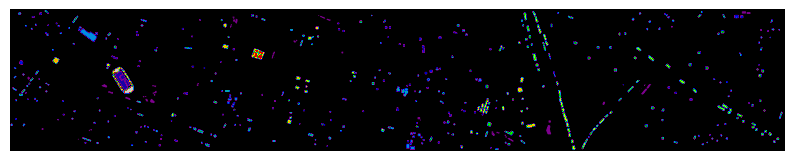

In [ ]:
## Test Prediction Model
start = time.time()
Te_Pre = model.predict(Te)
end = time.time()
Te_Time = end - start
classification,Confusion,OA,Per_Class,AA,Kappa = ClassificationReports(TeC, Te_Pre, target_names)
print(classification)

/home/ahmad/miniconda3/envs/hsi/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


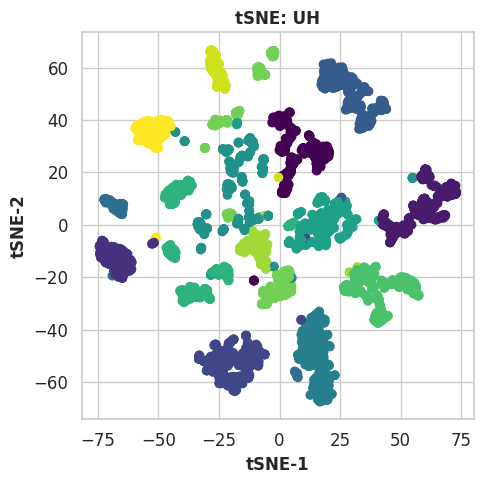

In [ ]:
# # Extract embeddings from the model
# embeddings = model.get_embeddings(Tr)
# embeddings_np = embeddings.numpy()
# tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
# embeddings_2d = tsne.fit_transform(embeddings_np)
# sns.set(style="whitegrid")
# plt.figure(figsize=(5, 5))
# plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=TrC.argmax(axis=1), cmap='viridis')
# plt.title(f'tSNE: {HSID}', fontsize=12, fontweight='bold')
# plt.xlabel('tSNE-1', fontsize=12, fontweight='bold')
# plt.ylabel('tSNE-2', fontsize=12, fontweight='bold')
# plt.tick_params(labelsize=12)
# plt.grid(True)
# plt.tight_layout()
# file_name = f"{HSID}_{teRatio}_{k}_{WS}_acc_loss_curve_all_models.png"
# plt.savefig(file_name, dpi=500, format='png', bbox_inches='tight', pad_inches=0)
# plt.show()

In [32]:
# # Plot training and validation loss and accuracy for each model on one graph
# fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# axs[0].plot(history.history['loss'], label='Train')
# axs[0].plot(history.history['val_loss'], label='Val', linestyle='--')
# # Plot accuracy
# axs[1].plot(history.history['accuracy'], label='Train')
# axs[1].plot(history.history['val_accuracy'], label='Val', linestyle='--')
# # Add labels and legend
# axs[0].set_title('Loss', fontsize=18, weight='bold')
# axs[0].set_xlabel('Epoch', fontsize=18, weight='bold')
# axs[1].set_title('Accuracy', fontsize=18, weight='bold')
# axs[1].set_xlabel('Epoch', fontsize=18, weight='bold')
# axs[1].legend(fontsize=24)
# # axs[0].set_xlabel('X-axis Label', fontsize=18, weight='bold')
# # axs[1].set_ylabel('Y-axis Label', fontsize=18, weight='bold')

# # Add grid lines and set background color
# axs[0].grid(True)
# axs[1].grid(True)
# # fig.patch.set_facecolor('#f2f2f2')
# plt.tight_layout()
# file_name = f"{HSID}_{teRatio}_{k}_{WS}_Loss_Acc.png"
# plt.savefig(file_name, dpi=500, format='png', bbox_inches='tight', pad_inches=0)
# files.download(file_name)
# plt.show()